Problem Statement
Predicting Survival in the Titanic Data Set We will be using a decision tree to make predictions about the Titanic data set from Kaggle. This data set provides information on the Titanic passengers and can be used to predict whether a passenger survived or not.


Variable Definition Key
survival Survival 0 = No, 1 = Yes
pclass Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
sex Sex
Age Age in years
sibsp # of siblings / spouses aboard the Titanic
parch # of parents / children aboard the Titanic
ticket Ticket number
fare Passenger fare
cabin Cabin number
embarked Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton
Variable Notes pclass: A proxy for socio-economic status (SES) 1st = Upper 2nd = Middle 3rd = Lower
age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
sibsp: The dataset defines family relations in this way... Sibling = brother, sister, stepbrother, stepsister Spouse = husband, wife (mistresses and fiancés were ignored)
parch: The dataset defines family relations in this way... Parent = mother, father Child = daughter, son, stepdaughter, stepson Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
#Hide all the warnings in jupyter notebook
import warnings 
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score,mean_absolute_error
import scikitplot
from sklearn.cross_validation import KFold
from  sklearn.model_selection import cross_val_predict
from sklearn.cross_validation import cross_val_score
from IPython.display import Image, display
import pydotplus
%matplotlib inline

In [5]:
url = 'https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv'
df = pd.read_csv(url)

In [6]:
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# SUMMARY STATISTCS¶


In [7]:
df.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Note :
It is evident that Age,cabin and embarked have null values associated with them hence the total count specific to each row does not matches.

In [9]:
#count of null values in Age column
df.Age.isnull().sum()


177

In [10]:
#count of null values in Embarked Column
df.Embarked.isnull().sum()

2

In [11]:
#count of null values in Cabin Column
df.Cabin.isnull().sum()

687

# DATA PREPROCESSING¶


In [12]:
#Age is a continuous variable .It contains 177 null varibales
#Imputing null values in Age column with median of Age values
df['Age'] = df['Age'].fillna(df['Age'].median())

In [13]:
df.Age.isnull().sum()


0

In [14]:
df_titanic = df.drop('Cabin',axis=1)


In [15]:
#drop null values from df_titanic
df_titanic.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.6+ KB


In [16]:
#Embarked column contains 2 null values .This can be removed without much affecting the model algorithm
df_titanic.dropna(inplace=True)

In [17]:
df_titanic.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


# DATA ANALYSIS THROUGH VISUALIZATION¶


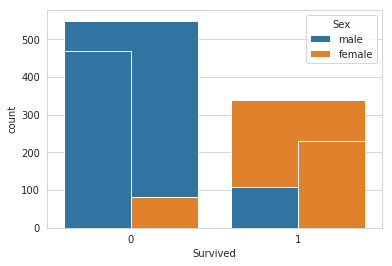

In [18]:
sb.set_style('whitegrid')
sb.countplot(x='Survived',data=df_titanic)
sb.countplot(x='Survived',data=df_titanic,hue='Sex')

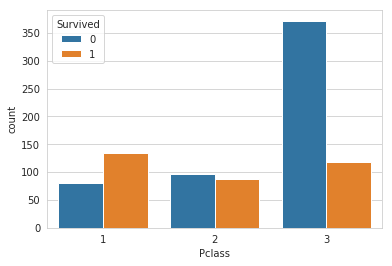

In [19]:
sb.countplot(x='Pclass',data=df_titanic,hue='Survived')


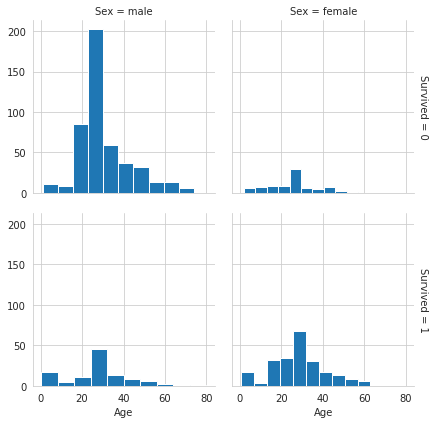

In [20]:
sb.FacetGrid(df_titanic, row="Survived", col="Sex", margin_titles=True).map(plt.hist, "Age")


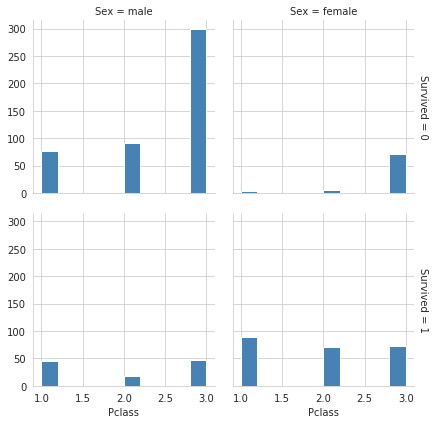

In [21]:
sb.FacetGrid(df_titanic, row="Survived", col="Sex", margin_titles=True).map(plt.hist, "Pclass", color="steelblue")

In [22]:
#Converting  Categorical Values into Numeric Values
df_titanic.Sex = df_titanic.Sex.map({'female':0,'male':1})
df_titanic.Sex.unique()

array([1, 0])

In [23]:
#using LabelEncoder fit and transform method to convert categorical values to numerical values
embarked_encoder = preprocessing.LabelEncoder()
embarked_encoder.fit(df_titanic.Embarked)
df_titanic.Embarked = embarked_encoder.transform(df_titanic.Embarked)
df_titanic.Embarked.unique()

array([2, 0, 1])

In [24]:
#Normalizing Age and Fare
age_scaler = StandardScaler()
age_scaler.fit(pd.DataFrame(df_titanic['Age']))
df_titanic.Age = age_scaler.transform(df_titanic[['Age']])
df_titanic.Age.unique()

array([-0.56367407,  0.66921696, -0.25545131,  0.43804989, -0.10133993,
        1.90210798, -2.10478785, -0.17839562, -1.18011958, -1.95067647,
        2.21033074, -0.71778544,  0.74627265,  1.97916367,  0.12982713,
        0.3609942 , -1.10306389, -1.64245371, -0.79484113,  0.82332834,
        2.82677625,  0.97743971, -0.64072976, -0.87189682, -2.02773216,
       -1.7195094 ,  1.51682954, -0.02428424,  2.74972056, -0.06281209,
       -1.87362078, -1.41128665,  1.20860678, -0.94895251,  0.20688282,
       -1.0260082 , -0.332507  , -2.194943  ,  0.05277145,  0.28393851,
       -0.48661838, -0.40956269,  1.28566247,  2.28738643,  3.21205469,
        0.59216127,  1.36271816, -1.14159173,  3.17352685,  0.24541067,
       -1.33423096, -1.56539802,  0.55363342,  1.67094091,  2.01769152,
        0.86185618,  1.13155109, -2.18184354,  2.4414978 ,  2.05621936,
        1.59388523,  0.51510558,  1.24713463, -0.6792576 ,  2.51855349,
        0.90038402,  1.7479966 ,  2.59560918, -0.44809053, -2.18

In [25]:
fare_scaler = StandardScaler()
fare_scaler.fit(pd.DataFrame(df_titanic['Fare']))

df_titanic['Fare'] = fare_scaler.transform(df_titanic[['Fare']])
df_titanic.Fare.unique()

array([-5.00239751e-01,  7.88946608e-01, -4.86649935e-01,  4.22861113e-01,
       -4.84133302e-01, -4.75912973e-01,  3.97946450e-01, -2.21900178e-01,
       -4.22057034e-01, -4.07871840e-02, -3.09982321e-01, -1.11671667e-01,
       -1.65429515e-02, -4.88075355e-01, -3.24075464e-01, -5.98290335e-02,
       -3.84474648e-01, -2.83809341e-01, -5.00743078e-01, -1.22744850e-01,
       -4.84552070e-01,  6.85192328e-02, -1.42779821e-02,  4.64879070e+00,
       -4.87572029e-01, -4.87237820e-01, -8.80998783e-02,  2.30370781e+00,
       -4.90173220e-01, -4.34807302e-01,  1.00814531e+00,  4.00714745e-01,
       -5.00658519e-01, -4.19874610e-01, -4.55443690e-01, -2.23410157e-01,
        1.90912139e-01, -3.34141995e-01, -2.09735782e-01, -2.87835954e-01,
        1.52826427e-01, -4.89166567e-01,  8.98589247e-01,  6.01626592e-01,
       -8.75119929e-02,  2.98036132e-01,  1.03440285e+00, -8.44920337e-02,
       -3.39259819e-01, -4.81952891e-01, -4.71801802e-01,  8.33575565e-01,
       -3.55197150e-01,  

In [26]:
df_titanic.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,-0.563674,1,0,A/5 21171,-0.500240,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0.669217,1,0,PC 17599,0.788947,0
2,3,1,3,"Heikkinen, Miss. Laina",0,-0.255451,0,0,STON/O2. 3101282,-0.486650,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0.438050,1,0,113803,0.422861,2
4,5,0,3,"Allen, Mr. William Henry",1,0.438050,0,0,373450,-0.484133,2


In [27]:
#Removed Survived from features as it is the label to be processed
#Removed PassengerId ,Name columns as it has not much significance.
X = df_titanic.drop(['Survived','PassengerId','Name','Ticket'],axis=1)
Y = df_titanic.Survived

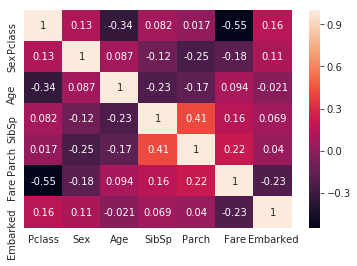

In [28]:
sb.heatmap(X.corr(),annot=True)


In [29]:
#create correlation matrix with absolute values
df_corr = X.corr().abs()
#select upper triangle of matrix
up_tri = df_corr.where(np.triu(np.ones(df_corr.shape[1]),k=1).astype(np.bool))

#find all the features which have a correlation > 0.75 with other features.
corr_features = [ column for column in up_tri.columns if any(up_tri[column]> 0.75)]

#Print Correlated features
print(corr_features)

[]


As evident from above no high correlation eists between these features¶


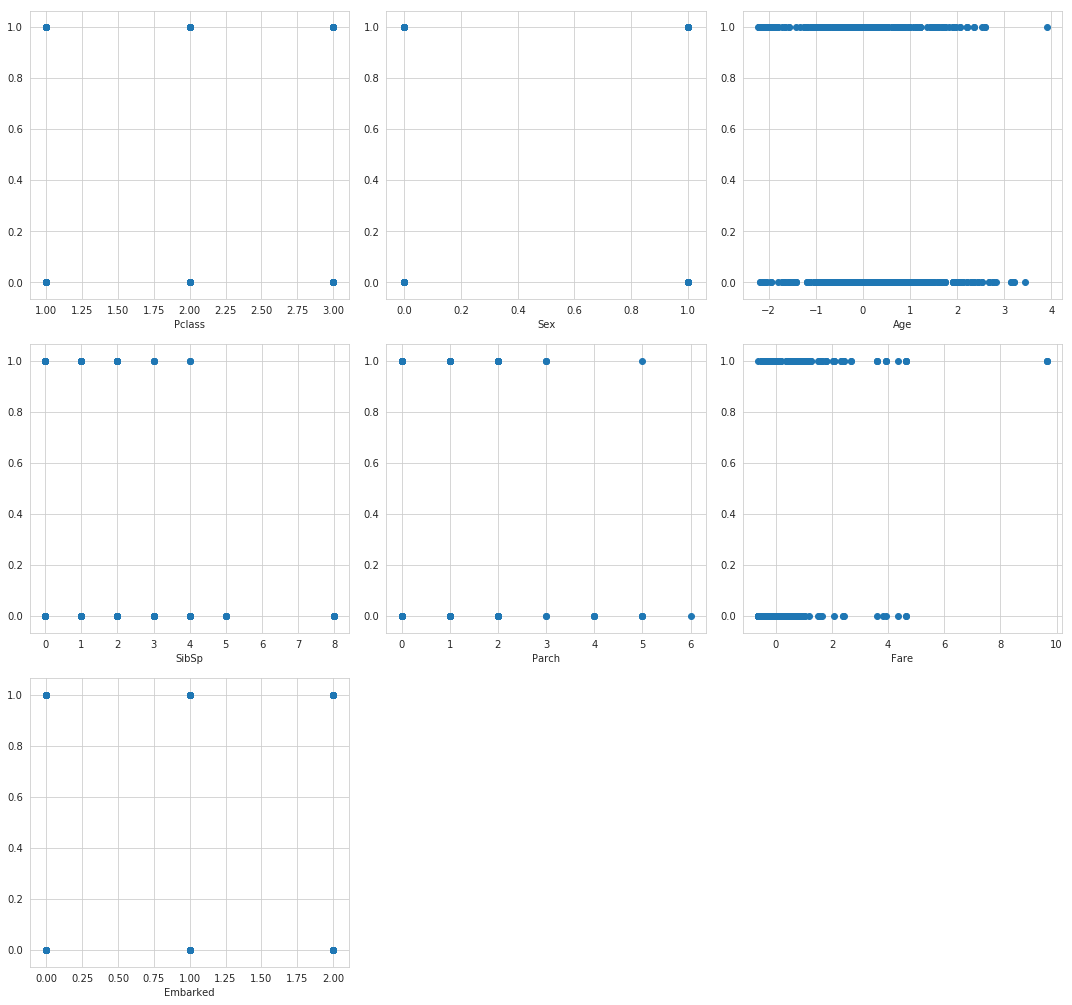

In [30]:
#Features against Survived (label)
fig = plt.figure(figsize = (15,60))
val = X.shape[1]
for idx in range(val):
    feature = X.columns[idx]
    ax = fig.add_subplot(13,3,idx+1)
    Xtmp = X[feature]
    ax.scatter(Xtmp, Y)
    ax.set_xlabel(feature)

plt.tight_layout()
plt.show()


# TRAIN TEST Split the dataset¶


In [31]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20,random_state=101)
print("X_train Shape : ",X_train.shape)
print("X_test Shape : ",X_test.shape)
print("Y_train Shape : ",Y_train.shape)
print("Y_test.shape : ",Y_test.shape)

X_train Shape :  (711, 7)
X_test Shape :  (178, 7)
Y_train Shape :  (711,)
Y_test.shape :  (178,)


In [32]:
X.isnull().sum()


Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

# CLASSIFICATION USING LOGISTIC REGRESSION¶


# 10 FOLD CROSS VALIDATON¶


In [33]:
kfold = KFold(len(X),n_folds=10,shuffle=True,random_state=0)
lr = LogisticRegression()
fold_accuracy = []
for train_fold, valid_fold in kfold:
    train = X.iloc[train_fold] # Extract train data with cv indices
    valid = X.iloc[valid_fold] # Extract valid data with cv indices
    
    train_y = Y.iloc[train_fold]
    valid_y = Y.iloc[valid_fold]
    
    model = lr.fit(train,train_y)
    valid_acc = model.score(X = valid, y = valid_y)
    fold_accuracy.append(valid_acc)    

print("Accuracy per fold: ", fold_accuracy, "\n")
print("Average accuracy: ", sum(fold_accuracy)/len(fold_accuracy))


Accuracy per fold:  [0.6404494382022472, 0.7640449438202247, 0.8764044943820225, 0.7865168539325843, 0.8876404494382022, 0.7865168539325843, 0.8202247191011236, 0.7528089887640449, 0.797752808988764, 0.8409090909090909] 

Average accuracy:  0.7953268641470889


Stratified K-Folds cross-validator¶
Provides train/test indices to split data in train/test sets.
This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [34]:
from sklearn.model_selection import StratifiedKFold
skfold = StratifiedKFold(n_splits=10, random_state=0, shuffle=False)
s_fold_accuracy = []
for train_fold, valid_fold in kfold:
    train = X.iloc[train_fold] # Extract train data with cv indices
    valid = X.iloc[valid_fold] # Extract valid data with cv indices
    
    train_y = Y.iloc[train_fold]
    valid_y = Y.iloc[valid_fold]
    
    model = lr.fit(train,train_y)
    valid_acc = model.score(X = valid, y = valid_y)
    s_fold_accuracy.append(valid_acc)    

print("Accuracy per fold: ", s_fold_accuracy, "\n")
print("Average accuracy: ", sum(s_fold_accuracy)/len(s_fold_accuracy))

Accuracy per fold:  [0.6404494382022472, 0.7640449438202247, 0.8764044943820225, 0.7865168539325843, 0.8876404494382022, 0.7865168539325843, 0.8202247191011236, 0.7528089887640449, 0.797752808988764, 0.8409090909090909] 

Average accuracy:  0.7953268641470889


Cross Validation Score for Logistic Regression¶


In [35]:
from sklearn.cross_validation import cross_val_score
model_result = {}
scores = cross_val_score(estimator= LogisticRegression(),     # Model to test
                X= X,  
                y = Y,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())
model_result['Logistic Regression CV Score'] = scores.mean()

Accuracy per fold: 
Cross Validation score:  [0.7752809  0.79775281 0.76404494 0.84269663 0.78651685 0.7752809
 0.78651685 0.7752809  0.80898876 0.81818182]
Average accuracy:  0.7930541368743615


In [36]:
coefficients = lr.coef_
coefficients

array([[-0.85596076, -2.38423105, -0.42526354, -0.30386435, -0.0219617 ,
         0.17602622, -0.19056199]])

In [37]:
features = X.columns.tolist()
features

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [38]:
coeff = []
i = 0
for col in X.columns:
    coeff.append(coefficients[0][i])
    i +=1
coeff

[-0.8559607594894905,
 -2.3842310451956954,
 -0.42526354018187595,
 -0.30386435198752515,
 -0.021961703480824043,
 0.17602622362565962,
 -0.19056198644832548]

# Check coefficients for the Logistic Regression Model¶


In [39]:
df_coeff = pd.DataFrame({'Features':features,'Coefficients':coeff})


In [40]:
df_coeff = df_coeff[['Features','Coefficients']]
df_coeff

,Features,Coefficients
0,Pclass,-0.855961
1,Sex,-2.384231
2,Age,-0.425264
3,SibSp,-0.303864
4,Parch,-0.021962
5,Fare,0.176026
6,Embarked,-0.190562


# Learning Curve of the Logistic Regression Classifier¶


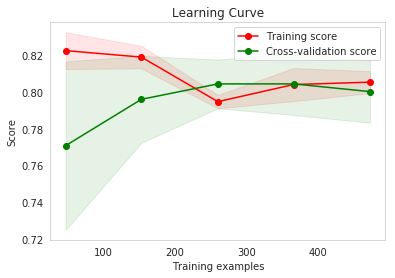

In [41]:
scikitplot.estimators.plot_learning_curve(lr,X_train,Y_train)


The learning curve contains two separate curves :
Training curve
Cross Validation Curve

Training score is high initially but it decreases with increasing number of examples.¶


Moving towards generalized solution the Cross Validation score increases as the training examples increases¶


Predictions Using Logistic Regression¶


In [42]:
Y_pred = lr.predict(X_test)


In [43]:
Y_pred


array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0])

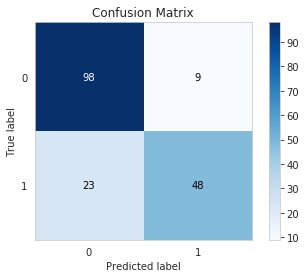

In [44]:
scikitplot.metrics.plot_confusion_matrix(Y_test,Y_pred)


In [45]:
print('Accuracy Score of Logistic Regression Model is  :',accuracy_score(Y_test,Y_pred))
model_result['Logistic Regression Test Accuracy'] = accuracy_score(Y_test,Y_pred)

Accuracy Score of Logistic Regression Model is  : 0.8202247191011236


In [46]:
print('Classification Report  of Logistic Regression Model is  : \n',classification_report(Y_test,Y_pred))

Classification Report  of Logistic Regression Model is  : 
              precision    recall  f1-score   support

          0       0.81      0.92      0.86       107
          1       0.84      0.68      0.75        71

avg / total       0.82      0.82      0.82       178



# RECEIVING OPERABILITY SCORE CURVE(ROC)¶


In [47]:
X_test.shape


(178, 7)

In [48]:
#Prediction probablity using Logistic Regression
Y_pred_proba = lr.predict_proba(X_test)

In [49]:
Y_pred_proba.shape


(178, 2)

In [50]:
class_1_prob = []
for i in Y_pred_proba:
    class_1_prob.append(i[1])
print("ROC Score : ",roc_auc_score(Y_test,class_1_prob))

ROC Score :  0.8874555745689088


/home/supratik/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


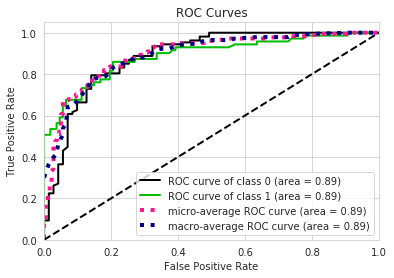

In [51]:
scikitplot.metrics.plot_roc_curve(Y_test,Y_pred_proba)


In [52]:
#Saving Model result
#model_result = {}
model_result['Logistic Regression L2'] = roc_auc_score(Y_test,class_1_prob)


# CLASSIFICATION USING DECISION TREES¶


# 10 FOLD CROSS VALIDATON¶


In [53]:
kfold = KFold(len(X),n_folds=10,shuffle=True,random_state=0)
#If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
dt = tree.DecisionTreeClassifier()
fold_accuracy = []
for train_fold, valid_fold in kfold:
    train = X.iloc[train_fold] # Extract training data with cv indices
    valid = X.iloc[valid_fold] # Extract validation data with cv indices
    
    train_y = Y.iloc[train_fold]
    valid_y = Y.iloc[valid_fold]
    
    model = dt.fit(train,train_y)
    valid_acc = model.score(X = valid, y = valid_y)
    fold_accuracy.append(valid_acc)    

print("Decision Tree Classifier Accuracy per fold: ", fold_accuracy, "\n")
print("Decision Tree Classifier Average accuracy: ", sum(fold_accuracy)/len(fold_accuracy))

Decision Tree Classifier Accuracy per fold:  [0.7415730337078652, 0.7415730337078652, 0.797752808988764, 0.7752808988764045, 0.7865168539325843, 0.7865168539325843, 0.8202247191011236, 0.6966292134831461, 0.8314606741573034, 0.7954545454545454] 

Decision Tree Classifier Average accuracy:  0.7772982635342185


Cross Validation Score for Decision Tree Classifier¶


In [54]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator= tree.DecisionTreeClassifier(random_state=0),     # Model to test
                X= X,  
                y = Y,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())
model_result['Decision Tree Classifier CV Score'] = scores.mean()

Accuracy per fold: 
Cross Validation score:  [0.71910112 0.82022472 0.70786517 0.7752809  0.84269663 0.78651685
 0.80898876 0.73033708 0.83146067 0.80681818]
Average accuracy:  0.7829290091930541


10 -Fold cross validation with tree depth as 2¶


In [55]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator= tree.DecisionTreeClassifier(max_depth=2,random_state=0),     # Model to test
                X= X,  
                y = Y,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())
model_result['Decision Tree Classifier depth 2 CV Score'] = scores.mean()

Accuracy per fold: 
Cross Validation score:  [0.69662921 0.75280899 0.74157303 0.83146067 0.79775281 0.7752809
 0.76404494 0.74157303 0.82022472 0.76136364]
Average accuracy:  0.7682711950970378


10 -Fold cross validation with tree depth as 4¶


In [56]:
scores = cross_val_score(estimator= tree.DecisionTreeClassifier(max_depth=4,random_state=0),     # Model to test
                X= X,  
                y = Y,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())
model_result['Decision Tree Classifier depth 4 CV Score'] = scores.mean()


Accuracy per fold: 
Cross Validation score:  [0.71910112 0.80898876 0.75280899 0.86516854 0.85393258 0.7752809
 0.78651685 0.75280899 0.87640449 0.84090909]
Average accuracy:  0.8031920326864148


10 -Fold cross validation with tree depth as 6¶


In [57]:
scores = cross_val_score(estimator= tree.DecisionTreeClassifier(max_depth=6,random_state=0),     # Model to test
                X= X,  
                y = Y,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())
model_result['Decision Tree Classifier depth 6 CV Score'] = scores.mean()

Accuracy per fold: 
Cross Validation score:  [0.73033708 0.82022472 0.73033708 0.82022472 0.84269663 0.83146067
 0.80898876 0.80898876 0.86516854 0.84090909]
Average accuracy:  0.8099336057201226


10 -Fold cross validation with tree depth as 08¶


In [58]:
scores = cross_val_score(estimator= tree.DecisionTreeClassifier(max_depth=8,random_state=0),     # Model to test
                X= X,  
                y = Y,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())
model_result['Decision Tree Classifier depth 8 CV Score'] = scores.mean()

Accuracy per fold: 
Cross Validation score:  [0.69662921 0.87640449 0.75280899 0.80898876 0.88764045 0.82022472
 0.80898876 0.76404494 0.8988764  0.79545455]
Average accuracy:  0.8110061287027579


10 -Fold cross validation with tree depth as 10¶


In [59]:
scores = cross_val_score(estimator= tree.DecisionTreeClassifier(max_depth=10,random_state=0),     # Model to test
                X= X,  
                y = Y,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())
model_result['Decision Tree Classifier depth 10 CV Score'] = scores.mean()

Accuracy per fold: 
Cross Validation score:  [0.70786517 0.82022472 0.70786517 0.82022472 0.85393258 0.79775281
 0.80898876 0.7752809  0.87640449 0.79545455]
Average accuracy:  0.7963993871297241


Note:-
From the above cross valid score it is evident that Decision Tree with Max_depth = 8 has the best cross validation score
Hence using the Decision Tree Classifier model with max_depth as 8 for prediction

In [60]:
kfold = KFold(len(X),n_folds=10,shuffle=True,random_state=0)
dt_8 = tree.DecisionTreeClassifier(max_depth=8,random_state=0)
fold_accuracy = []
for train_fold, valid_fold in kfold:
    train = X.iloc[train_fold] # Extract training data with cv indices
    valid = X.iloc[valid_fold] # Extract validation data with cv indices
    
    train_y = Y.iloc[train_fold]
    valid_y = Y.iloc[valid_fold]
    
    model = dt_8.fit(train,train_y)
    valid_acc = model.score(X = valid, y = valid_y)
    fold_accuracy.append(valid_acc)    

print("Decision Tree Classifier Accuracy per fold: ", fold_accuracy, "\n")
print("Decision Tree Classifier Average accuracy: ", sum(fold_accuracy)/len(fold_accuracy))

Decision Tree Classifier Accuracy per fold:  [0.7528089887640449, 0.7415730337078652, 0.797752808988764, 0.8202247191011236, 0.8764044943820225, 0.8089887640449438, 0.8651685393258427, 0.7640449438202247, 0.8202247191011236, 0.9090909090909091] 

Decision Tree Classifier Average accuracy:  0.8156281920326863


# Display the Decision Tree for the Problem Statement¶


In [61]:
import graphviz
import os
os.environ["PATH"] += os.pathsep + r'D:\Program Files (x86)\Graphviz2.38'
from IPython.display import Image

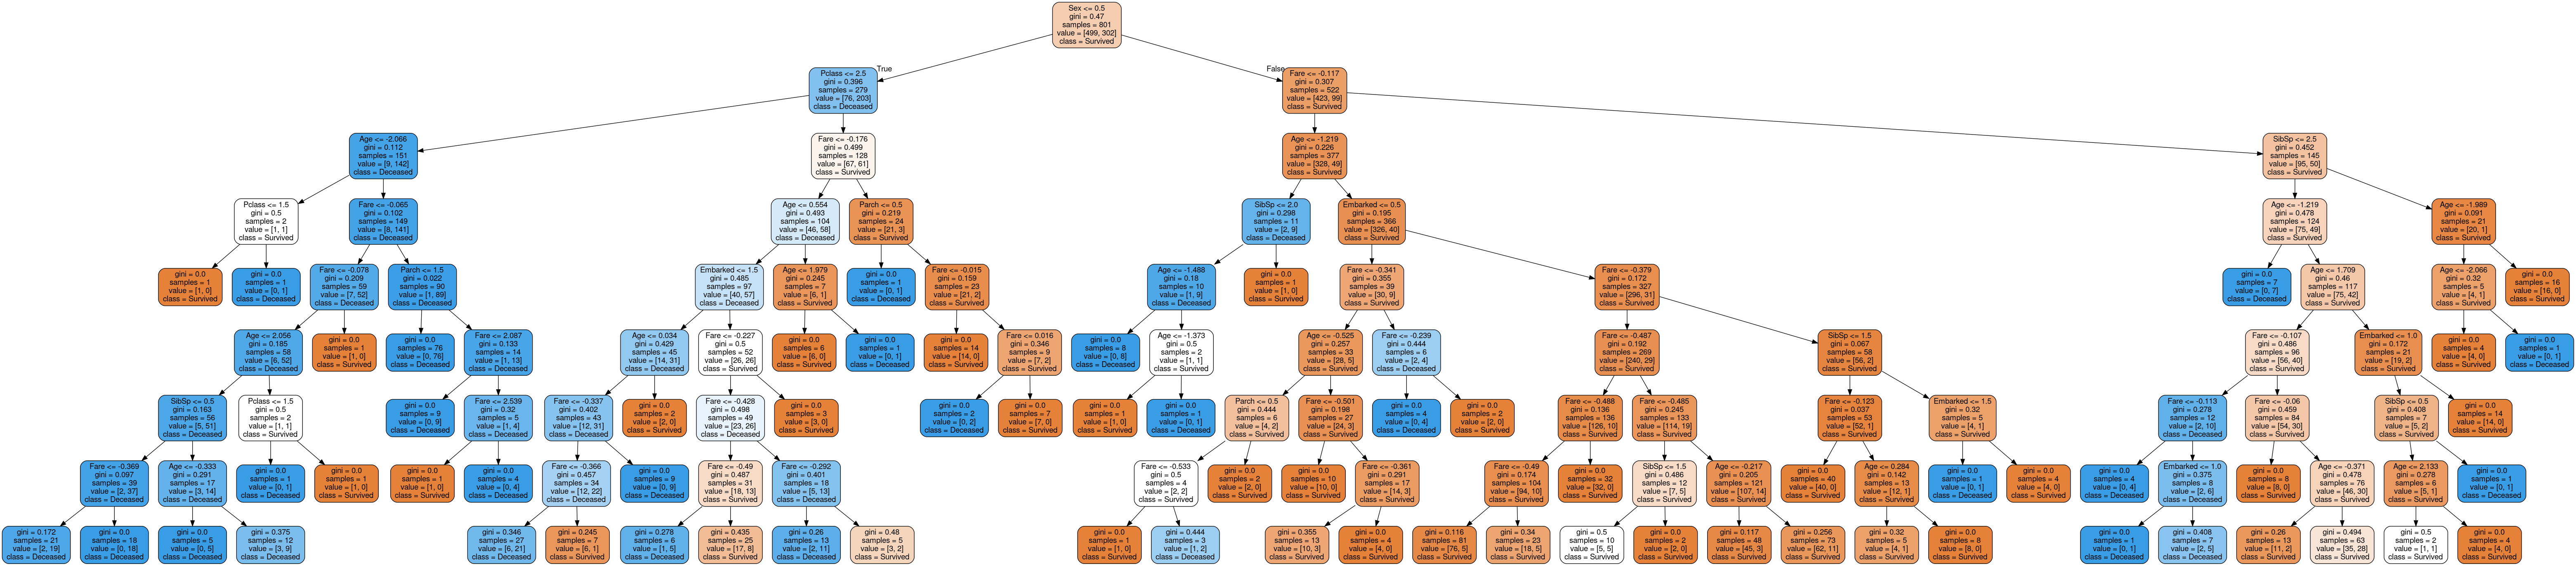

In [62]:
features = X.columns
labels = ['Survived','Deceased']
dot_data = tree.export_graphviz(dt_8, out_file=None, filled=True, rounded=True,
                                feature_names=features,  
                                class_names=labels)
graph = pydotplus.graph_from_dot_data(dot_data)  
display(Image(graph.create_png(),unconfined=True))

# Learning Curve in Descision Tree Classifier¶


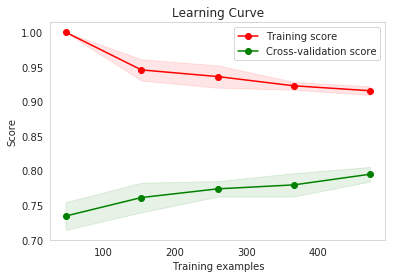

In [63]:
scikitplot.estimators.plot_learning_curve(dt_8,X_train,Y_train)


In [64]:
#Predict the Survival Class for the Test data
Y_pred = dt_8.predict(X_test)
#Prediction Probability
Y_pred_proba = dt_8.predict_proba(X_test)

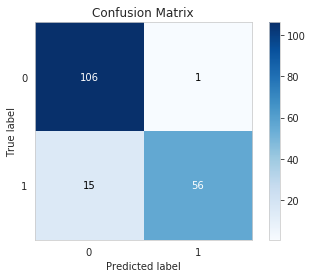

In [65]:
scikitplot.metrics.plot_confusion_matrix(Y_test,Y_pred)


/home/supratik/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


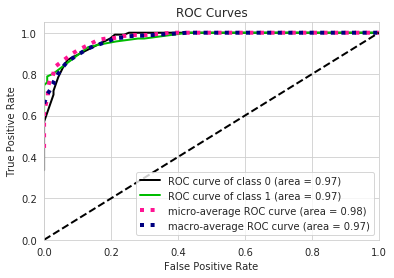

In [66]:
scikitplot.metrics.plot_roc_curve(Y_test,Y_pred_proba)


In [67]:
model_result['Decision Tree Classifier depth 8 Accuracy Score'] = accuracy_score(Y_test,Y_pred)
print('Accuracy Score of Decision Tree Classifier depth 8 : ',accuracy_score(Y_test,Y_pred))

Accuracy Score of Decision Tree Classifier depth 8 :  0.9101123595505618


In [68]:
print('Classification Report of Decision Tree Classifier depth 8 : ',classification_report(Y_test,Y_pred))

Classification Report of Decision Tree Classifier depth 8 :               precision    recall  f1-score   support

          0       0.88      0.99      0.93       107
          1       0.98      0.79      0.88        71

avg / total       0.92      0.91      0.91       178



In [69]:
class_1_prob = []
for i in Y_pred_proba:
    class_1_prob.append(i[1])
print("ROC Score : ",roc_auc_score(Y_test,class_1_prob))
model_result['Decision Tree Classifier depth 8 roc '] = roc_auc_score(Y_test,class_1_prob)


ROC Score :  0.9707779386599975


In [70]:
model_result


{'Logistic Regression CV Score': 0.7930541368743615,
 'Logistic Regression Test Accuracy': 0.8202247191011236,
 'Logistic Regression L2': 0.8874555745689088,
 'Decision Tree Classifier CV Score': 0.7829290091930541,
 'Decision Tree Classifier depth 2 CV Score': 0.7682711950970378,
 'Decision Tree Classifier depth 4 CV Score': 0.8031920326864148,
 'Decision Tree Classifier depth 6 CV Score': 0.8099336057201226,
 'Decision Tree Classifier depth 8 CV Score': 0.8110061287027579,
 'Decision Tree Classifier depth 10 CV Score': 0.7963993871297241,
 'Decision Tree Classifier depth 8 Accuracy Score': 0.9101123595505618,
 'Decision Tree Classifier depth 8 roc ': 0.9707779386599975}

In [71]:
features = []
scores = []
for k,v in model_result.items():
    features.append(k)
    scores.append(v)
print(features)
print(scores)


['Logistic Regression CV Score', 'Logistic Regression Test Accuracy', 'Logistic Regression L2', 'Decision Tree Classifier CV Score', 'Decision Tree Classifier depth 2 CV Score', 'Decision Tree Classifier depth 4 CV Score', 'Decision Tree Classifier depth 6 CV Score', 'Decision Tree Classifier depth 8 CV Score', 'Decision Tree Classifier depth 10 CV Score', 'Decision Tree Classifier depth 8 Accuracy Score', 'Decision Tree Classifier depth 8 roc ']
[0.7930541368743615, 0.8202247191011236, 0.8874555745689088, 0.7829290091930541, 0.7682711950970378, 0.8031920326864148, 0.8099336057201226, 0.8110061287027579, 0.7963993871297241, 0.9101123595505618, 0.9707779386599975]


In [72]:
df_scores = pd.DataFrame({'Features':features,'Scores':scores})
feat_cols = ['Features','Scores']
df_scores = df_scores[feat_cols]
df_scores

,Features,Scores
0,Logistic Regression CV Score,0.793054
1,Logistic Regression Test Accuracy,0.820225
2,Logistic Regression L2,0.887456
3,Decision Tree Classifier CV Score,0.782929
4,Decision Tree Classifier depth 2 CV Score,0.768271
5,Decision Tree Classifier depth 4 CV Score,0.803192
6,Decision Tree Classifier depth 6 CV Score,0.809934
7,Decision Tree Classifier depth 8 CV Score,0.811006
8,Decision Tree Classifier depth 10 CV Score,0.796399
9,Decision Tree Classifier depth 8 Accuracy Score,0.910112


# CONCLUSION :¶


After doing cross validation with max depth as 2,4,6,8,10 we could find that the optimum depth for which the cross validation score was hightest is 8.
The Decision Tree Classifier has a better cross validation score for max_depth 8 i.e 81%.
The Decision Tree Classifier for max depth 8 has an accuracy score of 91 % as compared to Logistic Regression Model having an accuracy score of 82 %.
Decision Tree improves accuracy as compared to Logistic Regression ##### We can conclude from above model estimation evaluation that the DECISION TREE CLASSIFIER is better compared to LOGISTIC REGRESSION model.